In [ ]:
# Standard library and path imports
import sys
import os

sys.path.append(".")
# Third-party library imports
import numpy as np
import pandas as pd
import shapely.ops as so
import shapely.geometry as sg
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx
import networkx as nx
import momepy
from shapely import wkt

from router import Router
from utils.dataparser import  create_network_graph, handle_weight
from utils.metrics import common_edges_similarity_route_df_weighted
import time
import json

# Read data

In [2]:
# Demo route

route_name =  "demo_walk"
route_id = "0"
basic_network_path = f'./examples/{route_name}/network_demo_walk_{route_id}'
foil_json_path = f'./examples/{route_name}/route_nodes_demo_walk_{route_id}.json'
df_path_foil_path = f'./examples/{route_name}/route_demo_walk_{route_id}'
gdf_coords_path = f'./examples/{route_name}/route_demo_walk_{route_id}_start_end.csv'
meta_data_path = f'./examples/{route_name}/metadata_{route_name}_{route_id}.json'

with open(meta_data_path, 'r') as f:
    meta_data = json.load(f)


with open(foil_json_path, 'r') as f:
    path_foil = json.load(f)

df_path_foil = gpd.read_file(df_path_foil_path)
gdf_coords_loaded = pd.read_csv(gdf_coords_path, sep=';')

gdf_coords_loaded['geometry'] = gdf_coords_loaded['geometry'].apply(wkt.loads)
gdf_coords_loaded = gpd.GeoDataFrame(gdf_coords_loaded, geometry='geometry')



# Profile settings
user_model = meta_data["user_model"]
meta_map = meta_data["map"]
attrs_variable_names = user_model["attrs_variable_names"]


df = gpd.read_file(basic_network_path)
df = handle_weight(df, user_model)
_, G_con_dir= create_network_graph(df )





## Get route

In [3]:

router_dijkstra = Router(heuristic="dijkstra",CRS=meta_map["CRS"],CRS_map=meta_map["CRS_map"])
origin_node_length, dest_node_length, origin_node_loc_length, dest_node_loc_length, gdf_coords = router_dijkstra.set_o_d_coords(G_con_dir, gdf_coords_loaded)
path_fact, G_path_fact, df_path_fact = router_dijkstra.get_route(G_con_dir,origin_node_length, dest_node_length, heuristic_f='my_weight')
sr_weighted = common_edges_similarity_route_df_weighted(df_path_fact,df_path_foil, attrs_variable_names)
print(df_path_fact['mm_len'].sum().round())
print(df_path_foil['mm_len'].sum().round())
print(f"Similarity ratio weighted: {sr_weighted}")

142.0
154.0
Similarity ratio weighted: 0.34632354


## Visualize route

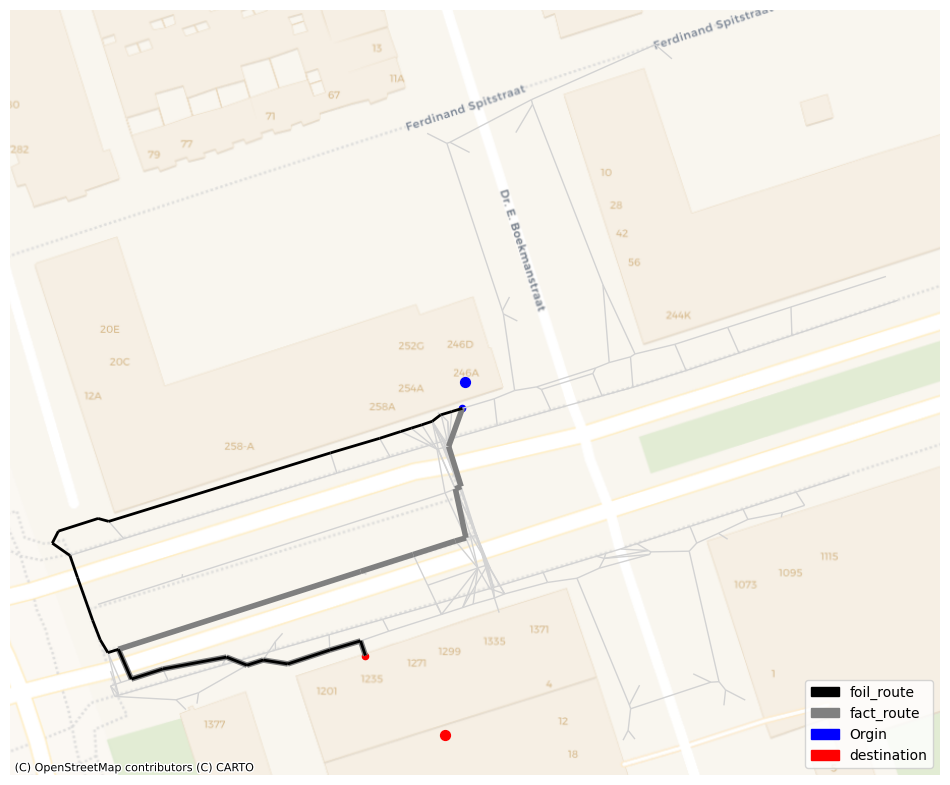

In [5]:
# Subset network for plotting
my_rad = 70
gdf_coords['buffer'] = gdf_coords['geometry'].buffer(my_rad, cap_style=3)
plot_area = gpd.GeoDataFrame(geometry=[gdf_coords['buffer'][0].union(gdf_coords['buffer'][1])], crs=meta_map["CRS"])
df_sub = gpd.sjoin(df, plot_area, how='inner').reset_index()

fig, ax = plt.subplots(figsize=(12,12))

# Network
df_sub.plot(ax=ax, color='lightgrey', linewidth=1)



df_path_fact.plot(ax=ax, color='grey', linewidth=4)

df_path_foil.plot(ax=ax, color='black', linewidth=2)

# Origin and destination location
gdf_coords.head(1).plot(ax=ax, color='blue', markersize=50)
gdf_coords.tail(1).plot(ax=ax, color='red', markersize=50)

# Origin and destination nodes
gpd.GeoSeries([origin_node_loc_length], crs=meta_map["CRS"]).plot(ax=ax, color='blue', markersize=20)
gpd.GeoSeries([dest_node_loc_length], crs=meta_map["CRS"]).plot(ax=ax, color='red', markersize=20)

# Background
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Voyager, crs=meta_map["CRS"])

# Legend
route_acc = mpatches.Patch(color='black', label='foil_route')
route = mpatches.Patch(color='grey', label='fact_route')
origin = mpatches.Patch(color='blue', label= 'Orgin')
dest = mpatches.Patch(color='red', label= 'destination')
legend_handles = [route_acc,route,origin,dest]


plt.legend(handles=legend_handles,loc="lower right")

plt.axis('off')

plt.show()